# Deep Q-Learning implementation -- CartPole

### Import libraries

In [1]:
%matplotlib inline

import os
import h5py
import gym
import numpy as np
import pandas as pd
import random
from numpy.random import randint
from collections import deque

from keras import initializations
from keras.initializations import normal, identity
from keras.models import load_model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD , Adam, Adagrad, RMSprop

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)


### Creating the game environment

In [2]:
GAME = 'CartPole-v0'
aux = gym.make(GAME)

[2017-01-22 19:40:31,034] Making new env: CartPole-v0



### Default parameters

In [4]:
# can be configured
BATCH_SIZE = 10
MAX_ITERATIONS_PER_EPISODE = 200
LEARNING_RATE = 0.00025
TARGET_UPDATE_LIMIT = 1
EPSILON = 1.0
EPSILON_UPDATE = 0.1
MIN_EPSILON = 0.1
GAMMA = 0.95
TERMINAL_REWARD = 1

# cannot be configured
INPUT_SIZE = aux.observation_space.shape[0]
OUTPUT_SIZE = aux.action_space.n
MIN_EXPERIENCE_REPLAY_SIZE = 1000
MAX_EXPERIENCE_REPLAY_SIZE = 100000

### Random positions for average q-value

In [6]:
SIZE=10000

random_states_filename = 'random_states.h5'
if not os.path.isfile(random_states_filename):
    print 'Generating random states'
    with h5py.File(random_states_filename, 'w') as h5:
        random_states = h5.create_dataset('random_states', (SIZE, INPUT_SIZE), dtype=np.float32)
        state = aux.reset()
        done = False
        for i in range(0, SIZE):
            if done:
                state = aux.reset()
                done = False
            else:
                state, _, done, _ = aux.step(aux.action_space.sample())                 
            random_states[i] = state
else:
    print 'Random states already exists'
            
random_states = np.zeros((SIZE, INPUT_SIZE), dtype=np.float32)
with h5py.File(random_states_filename, 'r') as h5:
    X = h5.get('random_states')
    for i in range(0, SIZE):
        random_states[i] = np.copy(X[i])

Generating random states



### Creating a scatterplot of a sample from random states

Just checking if random states look ok. Sample size = 100.

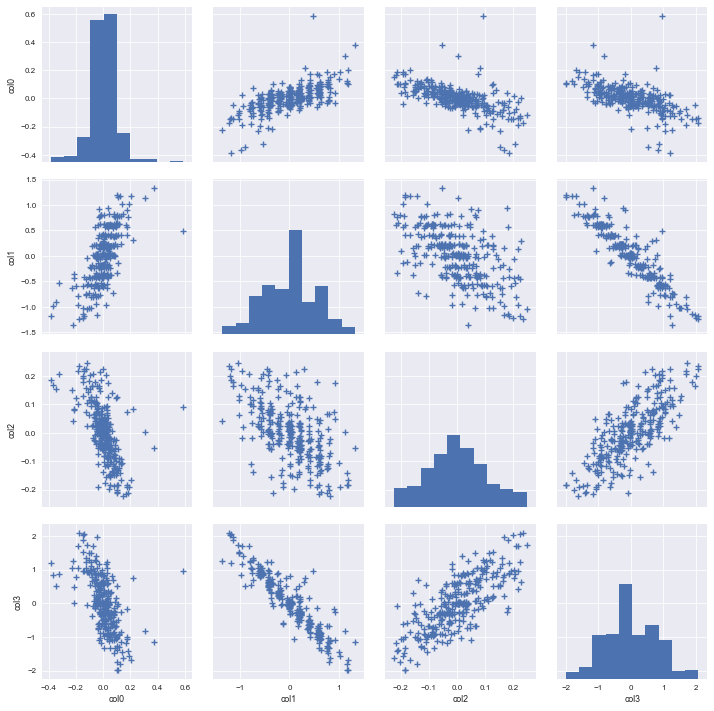

In [7]:
sns.set_context("paper")
sns.set_style('darkgrid')

df_rp = pd.DataFrame(random_states, columns=['col0', 'col1', 'col2', 'col3'])
sns.pairplot(df_rp.sample(n=300), markers='+')
plt.savefig('report/images/pairplot.pdf')

# Main source code

In [8]:
def build_model(learning_rate):
    """"Return the neural network"""
    model = Sequential()
    model.add(Dense(128, input_dim=INPUT_SIZE, init='normal', activation='relu'))
    model.add(Dense(128, init='normal', activation='relu'))    
    model.add(Dense(OUTPUT_SIZE, init='normal'))

    optimizer = SGD(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

class DeepQNetwork:
    
    def __init__(self, **kwargs):       
        if 'batch_size' in kwargs:
            self.batch_size = kwargs['batch_size']
        else:
            self.batch_size = BATCH_SIZE

        if 'min_experience_replay_size' in kwargs:
            self.minimum_experience_replay_size = kwargs['min_experience_replay_size']
        else:
            self.minimum_experience_replay_size = MIN_EXPERIENCE_REPLAY_SIZE
            
        if 'learning_rate' in kwargs:
            self.learning_rate = kwargs['learning_rate']
        else:
            self.learning_rate = LEARNING_RATE

        if 'epsilon' in kwargs:
            self.epsilon = kwargs['epsilon']
        else:
            self.epsilon = EPSILON
        
        if 'gamma' in kwargs:
            self.gamma = kwargs['gamma']
        else:
            self.gamma = GAMMA
            
        if 'target_update_limit' in kwargs:
            self.target_update_limit = kwargs['target_update_limit']
        else:
            self.target_update_limit = TARGET_UPDATE_LIMIT
            
        if 'max_iterations_per_episode' in kwargs:
            self.max_iterations_per_episode = kwargs['max_iterations_per_episode']
        else:
            self.max_iterations_per_episode = MAX_ITERATIONS_PER_EPISODE
            
        if 'min_epsilon' in kwargs:
            self.min_epsilon = kwargs['min_epsilon']
        else:
            self.min_epsilon = MIN_EPSILON
            
        if 'terminal_reward' in kwargs:
            self.terminal_reward = kwargs['terminal_reward']
        else:
            self.terminal_reward = TERMINAL_REWARD
            
        if 'epsilon_update' in kwargs:
            self.epsilon_update = kwargs['epsilon_update']
        else:
            self.epsilon_update = EPSILON_UPDATE
        
        self.last_action = None
        
        self.replay = deque()
        
        self.env = gym.make(GAME)
        
        self.reward_sum = 0
        self.total_episodes = 0
        
        self.episode_iterations = 0
        self.target_update = 0                
        
        self.model = build_model(self.learning_rate)
        self.frozen_model = build_model(self.learning_rate)
        
        
    def choose_best_action(self):
        """Return the action a that maximizes q(self.last_state, a)"""
        s = np.array([self.last_state])
        q = self.model.predict(s)[0]
        action = np.argmax(q)
        return action, q[action]

    
    def choose_random_action(self):
        return self.env.action_space.sample()
    
    
    def choose_e_greedy_action(self):
        """Return an action chosen following the e-greedy policy"""
        if random.random() <= self.epsilon:
            return self.choose_random_action()
        else:
            action, _ = self.choose_best_action()
            return action
        
        
    def execute_action(self, action):
        """Return the reward for executing the action and a boolean
           indicating if the new state is terminal.
        
        """
        state, original_reward, done, _ = self.env.step(action)        
        reward = original_reward
        self.reward_sum += reward
        
        if done:
            reward = self.terminal_reward
        
        data = (self.last_state, action, reward, state, done)                
        self.replay.append(data)                 
        
        if len(self.replay) > MAX_EXPERIENCE_REPLAY_SIZE:
            self.replay.popleft()

        self.episode_iterations += 1
        if done or self.episode_iterations >= self.max_iterations_per_episode:
            self.episode_iterations = 0
            done = True
            self.total_episodes += 1
            self.last_state = self.env.reset()
        else:
            self.last_state = state
                
        return original_reward, done
        
        
    def update_network(self):
        """Execute a mini-batch update
        """
        batch = random.sample(self.replay, self.batch_size - 1)
        batch.append(self.replay[-1])

        X_last = np.zeros((self.batch_size, INPUT_SIZE), dtype=np.float32)
        X_current = np.zeros((self.batch_size, INPUT_SIZE), dtype=np.float32)

        for i in range(0, BATCH_SIZE):
            ls, la, r, s, d = batch[i]
            X_last[i] = ls
            X_current[i] = s
            
        y = self.model.predict(X_last)
        
        self.target_update += 1        
        if self.target_update >= self.target_update_limit:
            self.target_update = 0
            self.frozen_model.set_weights(self.model.get_weights())
            
        q_theta = self.frozen_model.predict(X_current)
        
        for i in range(0, self.batch_size):
            ls, la, r, s, d = batch[i]

            if d:
                score = r
            else:
                score = r + self.gamma * np.max(q_theta[i])

            y[i][la] = score

        loss = self.model.train_on_batch(X_last, y)
        
        
    def run_test_average_reward(self, total_episodes, render): 
        """Run the environment without traning.
        
           Keyword arguments:
           total_episodes -- number of times the environment 
               will be run.
           render -- boolean indicating if the screen must be
               rendered
        """
        reward_sum = 0
        total_iterations = 0
                
        for _ in range(0, total_episodes):
            self.episode_iterations = 0
            self.last_state = self.env.reset()        
            done = False
            reward = 0
            
            while not done:
                if render:
                    self.env.render()
                    
                action, qvalue = self.choose_best_action()
                total_iterations += 1
                
                r, done = self.execute_action(action)
                reward += r              
            reward_sum += reward            
            
        avg_reward = reward_sum / float(total_episodes)
        
        return avg_reward
    
    
    def run_test_average_qvalue(self):
        """Calculate the average max q-value for the random_states"""
        y = self.model.predict(random_states)        
        return np.average(np.amax(y, axis=1))
        
            
    def train(self, total_frames, render):
        """Run the neural network training
        
           Keyword arguments:
           total_frames -- number of times the training process will be executed
           render -- if the screen should be rendered
           
        """
        self.last_state = self.env.reset()
               
        training_iterations = 0
        
        self.episode_iterations = 0
        while(training_iterations < total_frames):
            if render:
                self.env.render()           
        
            action = self.choose_e_greedy_action()
            self.execute_action(action)
            
            if len(self.replay) > MIN_EXPERIENCE_REPLAY_SIZE:
                training_iterations += 1
                self.update_network()
                
        # update epsilon        
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_update)

                
class Experiment:
    def __init__(self):
        self.data = []
        self.best_score = None
        
    def add_data(self, epoch, average_reward, average_qvalue):
        t = (epoch, average_reward, average_qvalue)
        self.data.append(t)
        
        
    def get_dataframe(self):
        df = pd.DataFrame(self.data, columns=['epoch', 'avg_reward', 'avg_qvalue'])
        return df
    
    
    def execute(self, epochs, dqn, model_name):    
        self.best_score = None 
        self.best_qvalue = None
        self.best_filename = None
        c = 0
        
        for i in tqdm(range(epochs)):
            c += 1
            
            filename = '/tmp/%s.%03d.h5'%(model_name, c)
            
            # train
            dqn.train(2000, False)                 

            # test
            avg_reward = dqn.run_test_average_reward(100, False)            
            avg_qvalue = dqn.run_test_average_qvalue()
            if self.best_score is None or avg_reward > self.best_score or \
                (avg_reward == self.best_score and avg_qvalue >= self.best_qvalue):
                    
                self.best_score = avg_reward
                self.best_qvalue = avg_qvalue
                self.best_filename = filename

            self.add_data(c, avg_reward, avg_qvalue)

            # save model            
            dqn.model.save_weights(filename)

            
def generate_graphic(filename, adjusted_qvalue, qvalue_range=[-100,150], reward_range=[0,250]):
    sns.set_context("paper")
    sns.set_style('dark')
    
    df = pd.DataFrame(experiment.get_dataframe(), columns=['epoch', 'avg_reward', 'avg_qvalue'])
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(df['epoch'], df['avg_reward'])
    if reward_range is not None:
        ax1.set_ylim(reward_range)
    ax1.set_xlabel('Number of epochs')
    ax1.set_ylabel('Average reward')
    
    ax1.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax1.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax1.grid(b=True, which='major', color='w', linewidth=1.5)
    ax1.grid(b=True, which='minor', color='w', linewidth=0.5)

    ax2 = ax1.twinx()
    ax2.plot(df['epoch'], df['avg_qvalue'] + adjusted_qvalue, color='r')
    ax2.set_ylabel('Average q-value')
    if qvalue_range is not None:
        ax2.set_ylim(qvalue_range)
    
    ax1.legend(loc=2)
    ax2.legend(loc=0)
    
    plt.savefig(filename)

# Experiments

The running timing for most of training is about 4 to 10 minutes, except when the maximum number of iterations in an episode is greater than the default value (200).

### Base model

[2017-01-22 19:42:57,970] Making new env: CartPole-v0
100%|██████████| 100/100 [12:38<00:00,  8.09s/it]


Best iteration
score: 182.38 | qvalue: 19.1490097046 | model: /tmp/base_model.038.h5


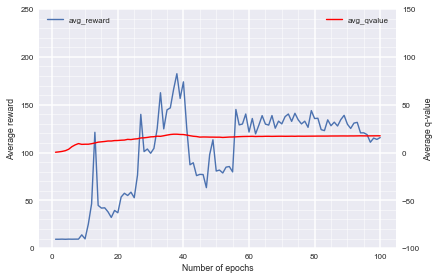

In [9]:
label = 'base_model'

config = {}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Learning rate 0.0001

[2017-01-22 19:55:37,294] Making new env: CartPole-v0
100%|██████████| 100/100 [12:06<00:00,  7.03s/it]


Best iteration
score: 171.14 | qvalue: 18.0362491608 | model: /tmp/learning_rate_0.0001.083.h5


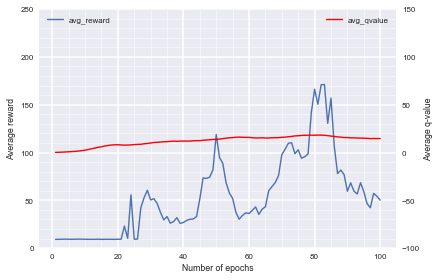

In [10]:
label = 'learning_rate_0.0001'

config = {
    'learning_rate' : 0.0001
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Target update 100

[2017-01-22 20:07:44,728] Making new env: CartPole-v0
100%|██████████| 100/100 [13:20<00:00,  8.42s/it]


Best iteration
score: 200.0 | qvalue: 18.7087574005 | model: /tmp/target_update_100.043.h5


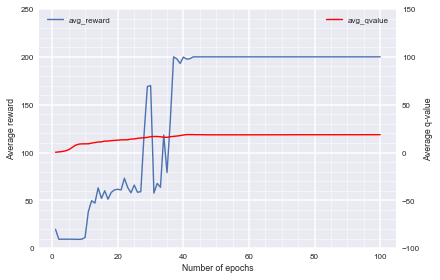

In [11]:
label = 'target_update_100'

config = {
    'target_update_limit' : 100
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Target update 200

[2017-01-22 20:21:05,434] Making new env: CartPole-v0
100%|██████████| 100/100 [13:00<00:00,  9.60s/it]


Best iteration
score: 200.0 | qvalue: 18.6927375793 | model: /tmp/target_update_200.099.h5


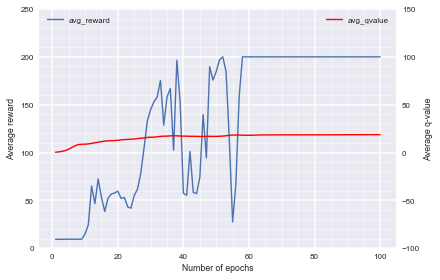

In [12]:
label = 'target_update_200'

config = {
    'target_update_limit' : 200
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Gamma 0.5

[2017-01-22 20:34:06,766] Making new env: CartPole-v0
100%|██████████| 100/100 [10:15<00:00,  6.25s/it]


Best iteration
score: 19.39 | qvalue: 0.288108021021 | model: /tmp/gamma_0_5.001.h5


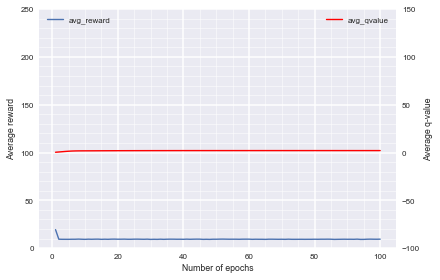

In [13]:
label = 'gamma_0_5'

config = {
    'gamma' : 0.5
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Reward at episode end = -1

[2017-01-22 20:54:02,014] Making new env: CartPole-v0
100%|██████████| 100/100 [13:19<00:00, 10.97s/it]


Best iteration
score: 200.0 | qvalue: 18.4702320099 | model: /tmp/reward_minus_one.098.h5


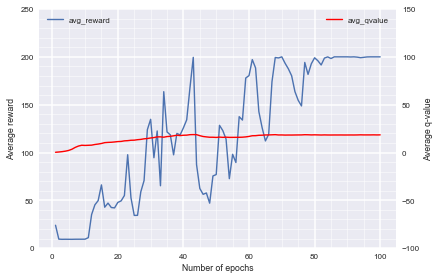

In [15]:
label = 'reward_minus_one'

config = {
    'terminal_reward' : -1
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Reward at episode end = -10

[2017-01-22 21:07:22,082] Making new env: CartPole-v0
100%|██████████| 100/100 [12:57<00:00,  8.58s/it]


Best iteration
score: 200.0 | qvalue: 17.9216136932 | model: /tmp/reward_minus_ten.065.h5


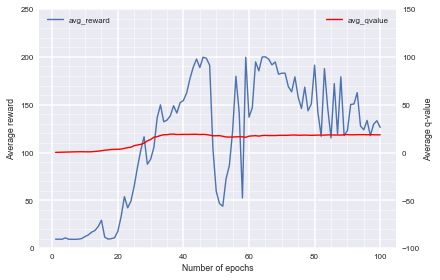

In [16]:
label = 'reward_minus_ten'

config = {
    'terminal_reward' : -10
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Reward at episode end = -100

[2017-01-22 21:20:19,906] Making new env: CartPole-v0
100%|██████████| 100/100 [16:56<00:00, 10.35s/it]


Best iteration
score: 200.0 | qvalue: 16.593000412 | model: /tmp/reward_minus_one_hundred.013.h5


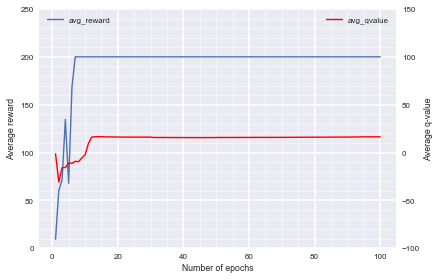

In [17]:
label = 'reward_minus_one_hundred'

config = {
    'terminal_reward' : -100
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Best model - restricted
- target update 200
- gamma 0.99
- reward at end -100
- learning rate 0.0001

[2017-01-22 21:37:17,019] Making new env: CartPole-v0
100%|██████████| 100/100 [12:46<00:00,  8.01s/it]


Best iteration
score: 200.0 | qvalue: 77.8779220581 | model: /tmp/best_restricted.100.h5


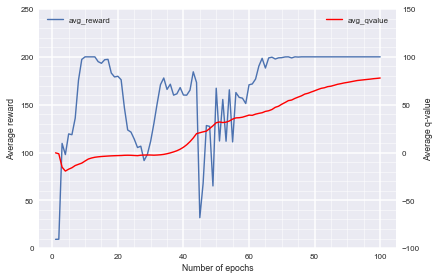

In [18]:
label = 'best_restricted'

config = {
    'terminal_reward' : -100,
    'gamma' : 0.99,
    'target_update_limit' : 200,
    'learning_rate' : 0.0001
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Best model - restricted
- target update 200
- gamma 0.99
- reward at end -100

[2017-01-22 22:09:03,694] Making new env: CartPole-v0
100%|██████████| 100/100 [13:59<00:00,  8.62s/it]


Best iteration
score: 200.0 | qvalue: 86.6461257935 | model: /tmp/best_restricted_2.100.h5


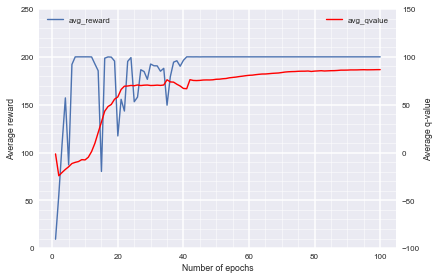

In [19]:
label = 'best_restricted_2'

config = {
    'terminal_reward' : -100,
    'gamma' : 0.99,
    'target_update_limit' : 200,
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(100, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0)

### Best model - unrestricted
- target update 200
- gamma 0.99
- reward at end -100
- max iterations per episode 1000
- learning rate 0.0001

[2017-01-22 22:23:03,993] Making new env: CartPole-v0
100%|██████████| 500/500 [2:34:28<00:00, 18.44s/it]


Best iteration
score: 1000.0 | qvalue: 91.9316635132 | model: /tmp/best_unrestricted.419.h5


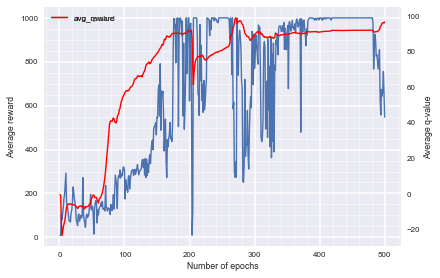

In [20]:
label = 'best_unrestricted'

config = {
    'terminal_reward' : -100,
    'gamma' : 0.99,
    'target_update_limit' : 200,
    'max_iterations_per_episode' : 1000,
    'learning_rate' : 0.0001
}

dqn = DeepQNetwork(**config)

experiment = Experiment()
experiment.execute(500, dqn, label)
print 'Best iteration'
print 'score: {} | qvalue: {} | model: {}' \
    .format(experiment.best_score, experiment.best_qvalue, experiment.best_filename)
generate_graphic('report/images/{}.pdf'.format(label), 0, None, None)

### Generating the graphic for previous model, setting the y_lim

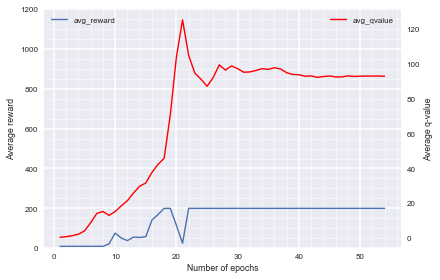

In [23]:
generate_graphic('report/images/{}.pdf'.format(label), 0, None, [0, 1200])

### Render an episode using best model found - iteration 090 from previous model

In [16]:
config = {
    'max_iterations_per_episode' : 5000000
}

dqn_test = DeepQNetwork(**config)
dqn_test.model.load_weights('best_model.h5')
score = dqn_test.run_test_average_reward(1, True)
print 'Score: {}'.format(score)

[2017-01-18 15:44:22,225] Making new env: CartPole-v0


Score: 5000000.0
